==============================================================================
03 - CNN-LSTM ADVANCED MODEL
==============================================================================

PURPOSE OF THIS NOTEBOOK:
-------------------------
Train and evaluate a CNN-LSTM neural network for price direction prediction.

This is our ADVANCED model because:
1. CNN layers capture local patterns (like candlestick patterns)
2. LSTM layers capture temporal dependencies (memory of past states)
3. Combination is powerful for sequential financial data

WHY CNN + LSTM?
---------------
- CNN: Good at finding local patterns in data (like chart patterns)
- LSTM: Good at remembering long-term dependencies
- Together: Can learn complex temporal patterns in price movements

EXPECTED RESULTS:
-----------------
- Neural networks often match or slightly beat tree-based models
- Main advantage: Can learn non-linear patterns automatically
- Main disadvantage: Slower training, needs more data


# CNN-LSTM Advanced Model

**Goal**: Train a deep learning model that can capture temporal patterns.

**Architecture**:
1. Input: Sequence of N past feature vectors (lookback window)
2. Conv1D: Extract local patterns
3. LSTM: Capture temporal dependencies
4. Dense: Classification into UP/SIDEWAYS/DOWN


In [1]:
# ==============================================================================
# IMPORTS AND GPU CHECK
# ==============================================================================
#
# TensorFlow/Keras is used for the neural network.
# We check for GPU availability because training is MUCH faster on GPU.

import sys
import os
from pathlib import Path

# Works both as script (__file__ exists) and in Jupyter (use cwd)
try:
    project_root = Path(__file__).resolve().parent.parent
except NameError:
    # Running in Jupyter - assume cwd is project root or notebooks/
    cwd = Path(os.getcwd())
    project_root = cwd.parent if cwd.name == 'notebooks' else cwd
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

# ==============================================================================
# GPU AVAILABILITY CHECK
# ==============================================================================
# Neural networks are 10-100x faster on GPU compared to CPU.
# If no GPU is detected, training will still work but be slower.

print("="*60)
print("🖥️ SYSTEM CHECK")
print("="*60)
print(f"TensorFlow version: {tf.__version__}")

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU available: {gpus[0].name}")
    print("   Training will be fast!")
else:
    print("⚠️ No GPU detected - training will be slower")
    print("   Consider using Google Colab for faster training")


2026-01-27 22:58:48.659966: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-27 22:58:49.103727: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-27 22:58:57.957023: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


🖥️ SYSTEM CHECK
TensorFlow version: 2.20.0
✅ GPU available: /physical_device:GPU:0
   Training will be fast!


In [2]:
# ==============================================================================
# IMPORT PROJECT MODULES
# ==============================================================================

# Reload modules to pick up any code changes without restarting kernel
import importlib
import src.data.loader
import src.labeling.oracle
import src.features.builder
import src.features.indicators
import src.models.cnn_lstm
importlib.reload(src.data.loader)
importlib.reload(src.labeling.oracle)
importlib.reload(src.features.builder)
importlib.reload(src.features.indicators)
importlib.reload(src.models.cnn_lstm)

from src.data.loader import load_and_merge_data, split_data_by_time
from src.labeling.oracle import create_oracle_labels
from src.features.builder import prepare_features
from src.features.indicators import get_indicator_columns
from src.models.cnn_lstm import CNNLSTMModel


## 1. Configuration

**NEW PARAMETER - LOOKBACK:**

Unlike XGBoost which sees one row at a time, CNN-LSTM sees a SEQUENCE of rows.
`LOOKBACK=20` means the model sees the last 20 candles (5 hours for 15-min data).

This allows the model to learn patterns like:
- "Price usually reverses after 3 consecutive red candles"
- "High volume followed by low volume often precedes breakouts"


In [3]:
# ==============================================================================
# CONFIGURATION PARAMETERS
# ==============================================================================

# Oracle label parameters (same as baseline for fair comparison)
SIGMA = 3           # Gaussian smoothing sigma
THRESHOLD = 0.0002  # Slope threshold for direction classification

# Prediction horizon
HORIZON = 1         # Predict next bar direction

# CNN-LSTM specific parameter
LOOKBACK = 10       # How many past candles to look at (10 showed better results than 20)
                    # 20 candles × 15 min = 5 hours of history
                    # Experiment with: 5, 10, 20, 30, 50

# Train/Test split dates
TRAIN_END = "2025-06-30"
TEST_START = "2025-07-01"

print("="*60)
print("📋 CONFIGURATION")
print("="*60)
print(f"Oracle: sigma={SIGMA}, threshold={THRESHOLD}")
print(f"Prediction Horizon: {HORIZON} bar(s)")
print(f"Lookback Window: {LOOKBACK} candles ({LOOKBACK * 15} minutes)")
print(f"Training: up to {TRAIN_END}")
print(f"Testing: from {TEST_START}")


📋 CONFIGURATION
Oracle: sigma=3, threshold=0.0002
Prediction Horizon: 1 bar(s)
Lookback Window: 10 candles (150 minutes)
Training: up to 2025-06-30
Testing: from 2025-07-01


## 2. Load and Prepare Data

Same data loading as baseline for fair comparison.


In [4]:
# ==============================================================================
# LOAD DATA AND CREATE LABELS
# ==============================================================================

print("\n" + "="*60)
print("📥 LOADING DATA")
print("="*60)

df = load_and_merge_data(end_date='2025-12-31')
df = create_oracle_labels(df, sigma=SIGMA, threshold=THRESHOLD)

print(f"\n✅ Loaded {len(df):,} rows")
print("\nLabel distribution:")
label_counts = df['target'].value_counts(normalize=True).sort_index()
label_names = {0: 'DOWN', 1: 'SIDEWAYS', 2: 'UP'}
for label, pct in label_counts.items():
    print(f"  {label_names[label]:8s}: {pct*100:5.1f}%")



📥 LOADING DATA

📥 LOADING DATA

✅ Loading pre-merged dataset: /mnt/c/_PYTH/projects/capstone_project/data/processed/all_merged.parquet
⏰ Filtered until: 2025-12-31

📊 Data Summary:
   Rows: 70,081
   Columns: 21
   Date range: 2024-01-01 00:00:00+00:00 to 2025-12-31 00:00:00+00:00

✅ Loaded 70,081 rows

Label distribution:
  DOWN    :  31.7%
  SIDEWAYS:  33.9%
  UP      :  34.4%


In [5]:
# ==============================================================================
# GENERATE FEATURES
# ==============================================================================
#
# For neural networks, we use fewer feature groups to avoid overfitting.
# Deep learning can learn features automatically, so we don't need as many.

print("\n" + "="*60)
print("⚙️ GENERATING FEATURES")
print("="*60)

# Use fewer groups for neural network (less prone to overfitting)
feature_groups = ['momentum', 'overlap', 'trend', 'volatility', 'volume', 'statistics']
df_features, group_map = prepare_features(df, groups=feature_groups, horizon=HORIZON)

print("\nFeature groups used:")
for group, cols in group_map.items():
    print(f"  {group}: {len(cols)} features")



⚙️ GENERATING FEATURES

🔧 PREPARING FEATURES
Groups to add: ['momentum', 'overlap', 'trend', 'volatility', 'volume', 'statistics']

📊 Adding indicators...
  -> Processing group: momentum
     Added 14 features: MOM_10, STOCHd_14_3_3, CCI_14_0.015, TSI_13_25_13, STOCHh_14_3_3...
  -> Processing group: overlap
[!] VWAP requires an ordered DatetimeIndex.
     Added 7 features: SMA_200, EMA_100, EMA_10, EMA_20, HMA_9...
  -> Processing group: trend
     Added 17 features: CKSPl_10_3_20, DMP_14, TRIXs_30_9, CKSPs_10_3_20, VTXP_14...
  -> Processing group: volatility
       BBL_20_2.0_2.0  BBM_20_2.0_2.0  BBU_20_2.0_2.0  BBB_20_2.0_2.0  \
0                 NaN             NaN             NaN             NaN   
1                 NaN             NaN             NaN             NaN   
2                 NaN             NaN             NaN             NaN   
3                 NaN             NaN             NaN             NaN   
4                 NaN             NaN             NaN             

In [6]:
# ==============================================================================
# TIME-BASED SPLIT
# ==============================================================================

print("\n" + "="*60)
print("📊 SPLITTING DATA")
print("="*60)

train_df, val_df, test_df = split_data_by_time(
    df_features,
    train_end=TRAIN_END,
    test_start=TEST_START,
    val_ratio=0.1  # Same as XGB for fair comparison
)

feature_cols = get_indicator_columns(
    df_features, 
    exclude_cols=['time', 'target', 'smoothed_close', 'smooth_slope']
)
feature_cols = [c for c in feature_cols if c in train_df.columns]
print(f"\n✅ Features: {len(feature_cols)}")



📊 SPLITTING DATA

📊 Data Split:
   Train: 46,947 rows (2024-01-03 15:30:00+00:00 to 2025-05-06 16:00:00+00:00)
   Val:   5,216 rows (2025-05-06 16:15:00+00:00 to 2025-06-30 00:00:00+00:00)
   Test:  17,568 rows (2025-07-01 00:00:00+00:00 to 2025-12-30 23:45:00+00:00)

✅ Features: 67


In [7]:
# ==============================================================================
# EXTRACT FEATURE MATRICES
# ==============================================================================
#
# Note: The CNN-LSTM model will internally convert these 2D arrays
# to 3D sequences using the LOOKBACK parameter.
# Shape: (samples, features) → (samples, lookback, features)

print("\n" + "="*60)
print("📐 EXTRACTING FEATURE MATRICES")
print("="*60)

X_train = train_df[feature_cols].values
y_train = train_df['target'].values.astype(int)

X_val = val_df[feature_cols].values
y_val = val_df['target'].values.astype(int)

X_test = test_df[feature_cols].values
y_test = test_df['target'].values.astype(int)

# Clean inf/nan values (some indicators like EOM produce inf from division by zero)
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
X_val = np.nan_to_num(X_val, nan=0.0, posinf=0.0, neginf=0.0)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

print(f"Training:   {X_train.shape[0]:,} samples × {X_train.shape[1]} features")
print(f"Validation: {X_val.shape[0]:,} samples × {X_val.shape[1]} features")
print(f"Test:       {X_test.shape[0]:,} samples × {X_test.shape[1]} features")

print(f"\n💡 After sequence creation (lookback={LOOKBACK}):")
print(f"   Input shape will be: (samples, {LOOKBACK}, {X_train.shape[1]})")



📐 EXTRACTING FEATURE MATRICES
Training:   46,947 samples × 67 features
Validation: 5,216 samples × 67 features
Test:       17,568 samples × 67 features

💡 After sequence creation (lookback=10):
   Input shape will be: (samples, 10, 67)


## 3. Train CNN-LSTM Model

**MODEL ARCHITECTURE:**

```
Input (lookback × features)
    ↓
Conv1D (extract local patterns)
    ↓
MaxPooling (reduce dimensionality)
    ↓
LSTM (capture temporal dependencies)
    ↓
Dropout (prevent overfitting)
    ↓
Dense (classification)
    ↓
Output (3 classes)
```

**Key Parameters:**
- `conv_filters`: Number of 1D convolution filters
- `lstm_units`: LSTM hidden state size
- `dropout`: Fraction of units to drop (regularization)
- `learning_rate`: Step size for optimizer


In [8]:
# ==============================================================================
# HYPERPARAMETER TUNING (GRID SEARCH)
# ==============================================================================
#
# Iterate over hyperparameter combinations to find the best model.
# Each combination is trained with fewer epochs for speed.

print("\n" + "="*60)
print("🔧 HYPERPARAMETER TUNING")
print("="*60)

# Parameters to search
PARAM_GRID = {
    'conv_filters': [16,32, 64, 128],           # Conv1D filters
    'dropout': [0.1, 0.2, 0.3],        # Dropout rate
    'learning_rate': [0.001,],   # Learning rate
    'lstm_units': [64, 96, 128],             # LSTM units
    'batch_size': [32, 64],             # Batch size
}

# Fast search with fewer epochs
SEARCH_EPOCHS = 20
SEARCH_PATIENCE = 7

print(f"\nSearch parameter grid:")
for param, values in PARAM_GRID.items():
    print(f"   {param}: {values}")

total_combinations = 1
for values in PARAM_GRID.values():
    total_combinations *= len(values)
print(f"\nTotal combinations: {total_combinations}")
print(f"Epochs per combination: {SEARCH_EPOCHS}")

# Run search
from itertools import product
import gc

results = []
best_val_acc = 0
best_params = {}

param_names = list(PARAM_GRID.keys())
param_values = list(PARAM_GRID.values())

for i, combo in enumerate(product(*param_values)):
    params = dict(zip(param_names, combo))
    
    print(f"\n[{i+1}/{total_combinations}] Testing: {params}")
    
    # Create model with these parameters
    test_model = CNNLSTMModel(
        n_classes=3,
        lookback=LOOKBACK,
        conv_filters=params['conv_filters'],
        lstm_units=params['lstm_units'],
        dropout=params['dropout'],
        learning_rate=params['learning_rate'],
        device='cuda',
        random_seed=42
    )
    
    # Quick training
    test_model.fit(
        X_train, y_train,
        X_val, y_val,
        feature_names=feature_cols,
        epochs=SEARCH_EPOCHS,
        batch_size=params['batch_size'],
        patience=SEARCH_PATIENCE,
        use_class_weights=True  # Handle class imbalance (SIDEWAYS ~40%)
    )
    
    # Evaluate on validation set
    val_metrics = test_model.evaluate(X_val, y_val)
    val_acc = val_metrics['accuracy']
    
    results.append({**params, 'val_accuracy': val_acc})
    print(f"   Val Accuracy: {val_acc:.4f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = params.copy()
        print(f"   ⭐ New best!")
    
    # Memory cleanup
    del test_model
    gc.collect()

# Search results
print("\n" + "="*60)
print("📊 TUNING RESULTS")
print("="*60)

import pandas as pd
results_df = pd.DataFrame(results).sort_values('val_accuracy', ascending=False)
print(results_df.to_string(index=False))

print(f"\n🏆 Best parameters:")
for param, value in best_params.items():
    print(f"   {param}: {value}")
print(f"   Val Accuracy: {best_val_acc:.4f}")

# Save best params to JSON for train.py to use
import json
best_params_to_save = {
    **best_params,
    'val_accuracy': best_val_acc,
    'lookback': LOOKBACK  # Include lookback used in grid search
}
Path('models_artifacts').mkdir(exist_ok=True)
with open('models_artifacts/cnn_lstm_best_params.json', 'w') as f:
    json.dump(best_params_to_save, f, indent=2)
print(f"\n✅ Best params saved: models_artifacts/cnn_lstm_best_params.json")



🔧 HYPERPARAMETER TUNING

Search parameter grid:
   conv_filters: [16, 32, 64, 128]
   dropout: [0.1, 0.2, 0.3]
   learning_rate: [0.001]
   lstm_units: [64, 96, 128]
   batch_size: [32, 64]

Total combinations: 72
Epochs per combination: 20

[1/72] Testing: {'conv_filters': 16, 'dropout': 0.1, 'learning_rate': 0.001, 'lstm_units': 64, 'batch_size': 32}
🚀 GPU detected: /physical_device:GPU:0

📊 Preparing data...
📊 Creating sequences (lookback=10)...
   Train sequences: (46937, 10, 67)
   Val sequences: (5206, 10, 67)

🏗️ Building model...


I0000 00:00:1769572749.411944   34914 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21768 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,123 (520.01 KB)

 Trainable params: 132,899 (519.14 KB)

 Non-trainable params: 224 (896.00 B)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20


2026-01-27 22:59:12.291040: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91800


1467/1467 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.4861 - loss: 1.0154 - val_accuracy: 0.5244 - val_loss: 0.9781 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5180 - loss: 0.9836 - val_accuracy: 0.5175 - val_loss: 0.9805 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5251 - loss: 0.9751 - val_accuracy: 0.5125 - val_loss: 0.9870 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5295 - loss: 0.9671 - val_accuracy: 0.5146 - val_loss: 0.9887 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5341 - loss: 0.9609 - val_accuracy: 0.4998 - val_loss: 0.9969 - learning_rate: 0.0010
Epoch 6/20
1466/1467 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5423 - loss: 0.9512
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5417 - 

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,123 (520.01 KB)

 Trainable params: 132,899 (519.14 KB)

 Non-trainable params: 224 (896.00 B)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.4856 - loss: 1.0154 - val_accuracy: 0.5115 - val_loss: 0.9923 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5201 - loss: 0.9805 - val_accuracy: 0.5113 - val_loss: 0.9828 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5252 - loss: 0.9691 - val_accuracy: 0.5165 - val_loss: 0.9834 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5325 - loss: 0.9615 - val_accuracy: 0.5050 - val_loss: 0.9940 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5406 - loss: 0.9529 - val_accuracy: 0.5050 - val_loss: 1.0075 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        49,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,139 (1.08 MB)

 Trainable params: 282,851 (1.08 MB)

 Non-trainable params: 288 (1.12 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.4881 - loss: 1.0142 - val_accuracy: 0.4818 - val_loss: 1.0035 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5131 - loss: 0.9860 - val_accuracy: 0.5102 - val_loss: 0.9833 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5243 - loss: 0.9769 - val_accuracy: 0.5029 - val_loss: 0.9936 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5276 - loss: 0.9693 - val_accuracy: 0.5048 - val_loss: 0.9929 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5331 - loss: 0.9605 - val_accuracy: 0.5023 - val_loss: 0.9940 - learning_rate: 0.0010
Epoch 6/20
1467/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        49,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,139 (1.08 MB)

 Trainable params: 282,851 (1.08 MB)

 Non-trainable params: 288 (1.12 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.4845 - loss: 1.0161 - val_accuracy: 0.5058 - val_loss: 1.0041 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5168 - loss: 0.9827 - val_accuracy: 0.5158 - val_loss: 0.9910 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5267 - loss: 0.9721 - val_accuracy: 0.5036 - val_loss: 0.9861 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5327 - loss: 0.9665 - val_accuracy: 0.5083 - val_loss: 0.9929 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5368 - loss: 0.9592 - val_accuracy: 0.5044 - val_loss: 1.0022 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 490,499 (1.87 MB)

 Trainable params: 490,147 (1.87 MB)

 Non-trainable params: 352 (1.38 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.4926 - loss: 1.0120 - val_accuracy: 0.4904 - val_loss: 1.0011 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5181 - loss: 0.9834 - val_accuracy: 0.4988 - val_loss: 0.9905 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5223 - loss: 0.9757 - val_accuracy: 0.4977 - val_loss: 0.9872 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5302 - loss: 0.9669 - val_accuracy: 0.5002 - val_loss: 0.9876 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5339 - loss: 0.9626 - val_accuracy: 0.4867 - val_loss: 1.0023 - learning_rate: 0.0010
Epoch 6/20
1467/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 490,499 (1.87 MB)

 Trainable params: 490,147 (1.87 MB)

 Non-trainable params: 352 (1.38 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.4871 - loss: 1.0141 - val_accuracy: 0.5115 - val_loss: 0.9967 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5193 - loss: 0.9808 - val_accuracy: 0.5138 - val_loss: 0.9862 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5277 - loss: 0.9713 - val_accuracy: 0.5123 - val_loss: 0.9945 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5349 - loss: 0.9634 - val_accuracy: 0.5194 - val_loss: 1.0006 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5404 - loss: 0.9548 - val_accuracy: 0.5077 - val_loss: 1.0049 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,123 (520.01 KB)

 Trainable params: 132,899 (519.14 KB)

 Non-trainable params: 224 (896.00 B)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.4825 - loss: 1.0184 - val_accuracy: 0.5025 - val_loss: 0.9923 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5128 - loss: 0.9882 - val_accuracy: 0.5144 - val_loss: 0.9842 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5185 - loss: 0.9814 - val_accuracy: 0.5131 - val_loss: 0.9818 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5199 - loss: 0.9785 - val_accuracy: 0.5192 - val_loss: 0.9790 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5239 - loss: 0.9737 - val_accuracy: 0.5136 - val_loss: 0.9840 - learning_rate: 0.0010
Epoch 6/20
1467/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,123 (520.01 KB)

 Trainable params: 132,899 (519.14 KB)

 Non-trainable params: 224 (896.00 B)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.4789 - loss: 1.0224 - val_accuracy: 0.5173 - val_loss: 0.9928 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5120 - loss: 0.9875 - val_accuracy: 0.5202 - val_loss: 0.9830 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5208 - loss: 0.9792 - val_accuracy: 0.5117 - val_loss: 0.9891 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5262 - loss: 0.9725 - val_accuracy: 0.5179 - val_loss: 0.9900 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5290 - loss: 0.9672 - val_accuracy: 0.5134 - val_loss: 0.9914 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        49,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,139 (1.08 MB)

 Trainable params: 282,851 (1.08 MB)

 Non-trainable params: 288 (1.12 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.4890 - loss: 1.0153 - val_accuracy: 0.4956 - val_loss: 0.9934 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5131 - loss: 0.9898 - val_accuracy: 0.5060 - val_loss: 0.9889 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5192 - loss: 0.9816 - val_accuracy: 0.5115 - val_loss: 0.9879 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5224 - loss: 0.9769 - val_accuracy: 0.5042 - val_loss: 0.9837 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5279 - loss: 0.9715 - val_accuracy: 0.5029 - val_loss: 0.9859 - learning_rate: 0.0010
Epoch 6/20
1467/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        49,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,139 (1.08 MB)

 Trainable params: 282,851 (1.08 MB)

 Non-trainable params: 288 (1.12 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.4801 - loss: 1.0248 - val_accuracy: 0.4948 - val_loss: 0.9915 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5117 - loss: 0.9903 - val_accuracy: 0.5094 - val_loss: 0.9816 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5207 - loss: 0.9801 - val_accuracy: 0.5015 - val_loss: 0.9879 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5248 - loss: 0.9750 - val_accuracy: 0.5081 - val_loss: 0.9886 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5283 - loss: 0.9693 - val_accuracy: 0.5061 - val_loss: 0.9838 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 490,499 (1.87 MB)

 Trainable params: 490,147 (1.87 MB)

 Non-trainable params: 352 (1.38 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.4765 - loss: 1.0226 - val_accuracy: 0.4952 - val_loss: 1.0004 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.5076 - loss: 0.9929 - val_accuracy: 0.5150 - val_loss: 0.9826 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5169 - loss: 0.9840 - val_accuracy: 0.5182 - val_loss: 0.9839 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5205 - loss: 0.9792 - val_accuracy: 0.5177 - val_loss: 0.9761 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.5247 - loss: 0.9736 - val_accuracy: 0.5061 - val_loss: 0.9846 - learning_rate: 0.0010
Epoch 6/20
1467/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 490,499 (1.87 MB)

 Trainable params: 490,147 (1.87 MB)

 Non-trainable params: 352 (1.38 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.4703 - loss: 1.0288 - val_accuracy: 0.5100 - val_loss: 0.9859 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5118 - loss: 0.9903 - val_accuracy: 0.5169 - val_loss: 0.9762 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5195 - loss: 0.9810 - val_accuracy: 0.5188 - val_loss: 0.9749 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.5221 - loss: 0.9752 - val_accuracy: 0.5175 - val_loss: 0.9797 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5278 - loss: 0.9700 - val_accuracy: 0.5154 - val_loss: 0.9814 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,123 (520.01 KB)

 Trainable params: 132,899 (519.14 KB)

 Non-trainable params: 224 (896.00 B)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.4718 - loss: 1.0277 - val_accuracy: 0.5152 - val_loss: 0.9904 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.5064 - loss: 0.9975 - val_accuracy: 0.5050 - val_loss: 0.9845 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.5132 - loss: 0.9894 - val_accuracy: 0.5211 - val_loss: 0.9739 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.5177 - loss: 0.9843 - val_accuracy: 0.5254 - val_loss: 0.9755 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.5190 - loss: 0.9808 - val_accuracy: 0.5181 - val_loss: 0.9807 - learning_rate: 0.0010
Epoch 6/20
1467/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,123 (520.01 KB)

 Trainable params: 132,899 (519.14 KB)

 Non-trainable params: 224 (896.00 B)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.4682 - loss: 1.0294 - val_accuracy: 0.5077 - val_loss: 0.9924 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5079 - loss: 0.9939 - val_accuracy: 0.5154 - val_loss: 0.9823 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5150 - loss: 0.9856 - val_accuracy: 0.5159 - val_loss: 0.9797 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.5213 - loss: 0.9802 - val_accuracy: 0.5100 - val_loss: 0.9849 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5237 - loss: 0.9756 - val_accuracy: 0.5231 - val_loss: 0.9765 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        49,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,139 (1.08 MB)

 Trainable params: 282,851 (1.08 MB)

 Non-trainable params: 288 (1.12 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.4813 - loss: 1.0257 - val_accuracy: 0.4958 - val_loss: 1.0052 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5080 - loss: 0.9958 - val_accuracy: 0.4900 - val_loss: 1.0005 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5146 - loss: 0.9892 - val_accuracy: 0.5096 - val_loss: 0.9797 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5145 - loss: 0.9864 - val_accuracy: 0.5152 - val_loss: 0.9792 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.5201 - loss: 0.9819 - val_accuracy: 0.5179 - val_loss: 0.9819 - learning_rate: 0.0010
Epoch 6/20
1467/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        49,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,139 (1.08 MB)

 Trainable params: 282,851 (1.08 MB)

 Non-trainable params: 288 (1.12 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.4690 - loss: 1.0298 - val_accuracy: 0.5202 - val_loss: 0.9803 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5063 - loss: 0.9952 - val_accuracy: 0.5277 - val_loss: 0.9730 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5136 - loss: 0.9863 - val_accuracy: 0.5209 - val_loss: 0.9759 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.5184 - loss: 0.9812 - val_accuracy: 0.5119 - val_loss: 0.9784 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5223 - loss: 0.9763 - val_accuracy: 0.5075 - val_loss: 0.9772 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 490,499 (1.87 MB)

 Trainable params: 490,147 (1.87 MB)

 Non-trainable params: 352 (1.38 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.4747 - loss: 1.0264 - val_accuracy: 0.5158 - val_loss: 0.9894 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.5060 - loss: 0.9958 - val_accuracy: 0.5315 - val_loss: 0.9711 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.5122 - loss: 0.9879 - val_accuracy: 0.5259 - val_loss: 0.9727 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.5160 - loss: 0.9828 - val_accuracy: 0.5077 - val_loss: 0.9811 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5189 - loss: 0.9809 - val_accuracy: 0.5058 - val_loss: 0.9843 - learning_rate: 0.0010
Epoch 6/20
1467/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 490,499 (1.87 MB)

 Trainable params: 490,147 (1.87 MB)

 Non-trainable params: 352 (1.38 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.4723 - loss: 1.0297 - val_accuracy: 0.5232 - val_loss: 0.9797 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5052 - loss: 0.9954 - val_accuracy: 0.5194 - val_loss: 0.9726 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5137 - loss: 0.9861 - val_accuracy: 0.5204 - val_loss: 0.9719 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5178 - loss: 0.9819 - val_accuracy: 0.5198 - val_loss: 0.9722 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5244 - loss: 0.9767 - val_accuracy: 0.5225 - val_loss: 0.9744 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,379 (583.51 KB)

 Trainable params: 149,059 (582.26 KB)

 Non-trainable params: 320 (1.25 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.4933 - loss: 1.0080 - val_accuracy: 0.5073 - val_loss: 0.9974 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.5195 - loss: 0.9793 - val_accuracy: 0.5025 - val_loss: 1.0057 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5270 - loss: 0.9684 - val_accuracy: 0.5075 - val_loss: 0.9968 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.5354 - loss: 0.9580 - val_accuracy: 0.4831 - val_loss: 1.0157 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.5458 - loss: 0.9463 - val_accuracy: 0.4931 - val_loss: 1.0097 - learning_rate: 0.0010
Epoch 6/20
1464/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,379 (583.51 KB)

 Trainable params: 149,059 (582.26 KB)

 Non-trainable params: 320 (1.25 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.4947 - loss: 1.0069 - val_accuracy: 0.5181 - val_loss: 0.9831 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5237 - loss: 0.9742 - val_accuracy: 0.5144 - val_loss: 0.9792 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5356 - loss: 0.9586 - val_accuracy: 0.5058 - val_loss: 0.9920 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5445 - loss: 0.9468 - val_accuracy: 0.5044 - val_loss: 1.0011 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5547 - loss: 0.9322 - val_accuracy: 0.5006 - val_loss: 1.0109 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 303,491 (1.16 MB)

 Trainable params: 303,107 (1.16 MB)

 Non-trainable params: 384 (1.50 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.4897 - loss: 1.0115 - val_accuracy: 0.5038 - val_loss: 0.9899 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.5185 - loss: 0.9810 - val_accuracy: 0.5111 - val_loss: 0.9884 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.5267 - loss: 0.9709 - val_accuracy: 0.5146 - val_loss: 0.9909 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5321 - loss: 0.9596 - val_accuracy: 0.4965 - val_loss: 0.9999 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5414 - loss: 0.9492 - val_accuracy: 0.5040 - val_loss: 1.0056 - learning_rate: 0.0010
Epoch 6/20
1467/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 303,491 (1.16 MB)

 Trainable params: 303,107 (1.16 MB)

 Non-trainable params: 384 (1.50 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.4925 - loss: 1.0084 - val_accuracy: 0.5148 - val_loss: 0.9822 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5223 - loss: 0.9755 - val_accuracy: 0.5156 - val_loss: 0.9837 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5313 - loss: 0.9624 - val_accuracy: 0.5075 - val_loss: 0.9876 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5399 - loss: 0.9515 - val_accuracy: 0.4979 - val_loss: 1.0021 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5489 - loss: 0.9382 - val_accuracy: 0.4998 - val_loss: 1.0083 - learning_rate: 0.0010
Epoch 6/20
733/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 514,947 (1.96 MB)

 Trainable params: 514,499 (1.96 MB)

 Non-trainable params: 448 (1.75 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.4933 - loss: 1.0103 - val_accuracy: 0.4979 - val_loss: 1.0132 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5208 - loss: 0.9800 - val_accuracy: 0.5123 - val_loss: 0.9812 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5271 - loss: 0.9702 - val_accuracy: 0.5006 - val_loss: 0.9948 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5352 - loss: 0.9605 - val_accuracy: 0.5040 - val_loss: 0.9991 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5439 - loss: 0.9482 - val_accuracy: 0.5090 - val_loss: 0.9970 - learning_rate: 0.0010
Epoch 6/20
1467/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 514,947 (1.96 MB)

 Trainable params: 514,499 (1.96 MB)

 Non-trainable params: 448 (1.75 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.4908 - loss: 1.0124 - val_accuracy: 0.5136 - val_loss: 0.9885 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5218 - loss: 0.9769 - val_accuracy: 0.5102 - val_loss: 0.9802 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5327 - loss: 0.9638 - val_accuracy: 0.5142 - val_loss: 0.9871 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.5381 - loss: 0.9536 - val_accuracy: 0.5257 - val_loss: 0.9864 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5505 - loss: 0.9406 - val_accuracy: 0.5023 - val_loss: 1.0095 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,379 (583.51 KB)

 Trainable params: 149,059 (582.26 KB)

 Non-trainable params: 320 (1.25 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.4889 - loss: 1.0137 - val_accuracy: 0.4981 - val_loss: 0.9965 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5170 - loss: 0.9843 - val_accuracy: 0.5123 - val_loss: 0.9831 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5256 - loss: 0.9748 - val_accuracy: 0.5109 - val_loss: 0.9884 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5298 - loss: 0.9690 - val_accuracy: 0.5073 - val_loss: 0.9932 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5342 - loss: 0.9617 - val_accuracy: 0.5060 - val_loss: 0.9936 - learning_rate: 0.0010
Epoch 6/20
1467/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,379 (583.51 KB)

 Trainable params: 149,059 (582.26 KB)

 Non-trainable params: 320 (1.25 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.4867 - loss: 1.0151 - val_accuracy: 0.5036 - val_loss: 0.9970 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5192 - loss: 0.9821 - val_accuracy: 0.5207 - val_loss: 0.9787 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5261 - loss: 0.9702 - val_accuracy: 0.5136 - val_loss: 0.9830 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5352 - loss: 0.9614 - val_accuracy: 0.5144 - val_loss: 0.9964 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5394 - loss: 0.9523 - val_accuracy: 0.5127 - val_loss: 0.9938 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 303,491 (1.16 MB)

 Trainable params: 303,107 (1.16 MB)

 Non-trainable params: 384 (1.50 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.4885 - loss: 1.0144 - val_accuracy: 0.4973 - val_loss: 0.9970 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5149 - loss: 0.9861 - val_accuracy: 0.5094 - val_loss: 0.9828 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5211 - loss: 0.9760 - val_accuracy: 0.4981 - val_loss: 0.9899 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5261 - loss: 0.9691 - val_accuracy: 0.4975 - val_loss: 0.9885 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5318 - loss: 0.9631 - val_accuracy: 0.5031 - val_loss: 0.9909 - learning_rate: 0.0010
Epoch 6/20
1467/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 303,491 (1.16 MB)

 Trainable params: 303,107 (1.16 MB)

 Non-trainable params: 384 (1.50 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.4846 - loss: 1.0147 - val_accuracy: 0.5242 - val_loss: 0.9761 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5196 - loss: 0.9808 - val_accuracy: 0.5085 - val_loss: 0.9848 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5265 - loss: 0.9702 - val_accuracy: 0.5079 - val_loss: 0.9894 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5315 - loss: 0.9639 - val_accuracy: 0.4987 - val_loss: 0.9906 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.5381 - loss: 0.9554 - val_accuracy: 0.5144 - val_loss: 0.9898 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 514,947 (1.96 MB)

 Trainable params: 514,499 (1.96 MB)

 Non-trainable params: 448 (1.75 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.4883 - loss: 1.0143 - val_accuracy: 0.5054 - val_loss: 0.9941 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5159 - loss: 0.9853 - val_accuracy: 0.5000 - val_loss: 0.9908 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5203 - loss: 0.9777 - val_accuracy: 0.5048 - val_loss: 0.9846 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5274 - loss: 0.9712 - val_accuracy: 0.5158 - val_loss: 0.9782 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5307 - loss: 0.9640 - val_accuracy: 0.5008 - val_loss: 0.9930 - learning_rate: 0.0010
Epoch 6/20
1467/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 514,947 (1.96 MB)

 Trainable params: 514,499 (1.96 MB)

 Non-trainable params: 448 (1.75 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.4917 - loss: 1.0117 - val_accuracy: 0.5231 - val_loss: 0.9803 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5200 - loss: 0.9812 - val_accuracy: 0.5248 - val_loss: 0.9838 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5238 - loss: 0.9716 - val_accuracy: 0.5198 - val_loss: 0.9848 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5309 - loss: 0.9626 - val_accuracy: 0.5177 - val_loss: 0.9986 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5331 - loss: 0.9573 - val_accuracy: 0.5063 - val_loss: 1.0137 - learning_rate: 0.0010
Epoch 6/20
733/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,379 (583.51 KB)

 Trainable params: 149,059 (582.26 KB)

 Non-trainable params: 320 (1.25 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.4823 - loss: 1.0189 - val_accuracy: 0.5171 - val_loss: 0.9880 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5135 - loss: 0.9896 - val_accuracy: 0.5106 - val_loss: 0.9836 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5187 - loss: 0.9821 - val_accuracy: 0.5173 - val_loss: 0.9835 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5233 - loss: 0.9759 - val_accuracy: 0.5140 - val_loss: 0.9831 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5278 - loss: 0.9699 - val_accuracy: 0.5231 - val_loss: 0.9795 - learning_rate: 0.0010
Epoch 6/20
1467/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,379 (583.51 KB)

 Trainable params: 149,059 (582.26 KB)

 Non-trainable params: 320 (1.25 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.4757 - loss: 1.0239 - val_accuracy: 0.5163 - val_loss: 0.9916 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5132 - loss: 0.9880 - val_accuracy: 0.5117 - val_loss: 0.9863 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5182 - loss: 0.9805 - val_accuracy: 0.5225 - val_loss: 0.9774 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5239 - loss: 0.9743 - val_accuracy: 0.5240 - val_loss: 0.9774 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5292 - loss: 0.9678 - val_accuracy: 0.5129 - val_loss: 0.9821 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 303,491 (1.16 MB)

 Trainable params: 303,107 (1.16 MB)

 Non-trainable params: 384 (1.50 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.4843 - loss: 1.0175 - val_accuracy: 0.5202 - val_loss: 0.9821 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5109 - loss: 0.9896 - val_accuracy: 0.5121 - val_loss: 0.9831 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5187 - loss: 0.9826 - val_accuracy: 0.5115 - val_loss: 0.9832 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5260 - loss: 0.9749 - val_accuracy: 0.5046 - val_loss: 0.9818 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5282 - loss: 0.9690 - val_accuracy: 0.5119 - val_loss: 0.9829 - learning_rate: 0.0010
Epoch 6/20
1467/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 303,491 (1.16 MB)

 Trainable params: 303,107 (1.16 MB)

 Non-trainable params: 384 (1.50 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.4837 - loss: 1.0174 - val_accuracy: 0.5081 - val_loss: 0.9838 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5156 - loss: 0.9866 - val_accuracy: 0.5073 - val_loss: 0.9832 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5210 - loss: 0.9786 - val_accuracy: 0.5207 - val_loss: 0.9793 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5279 - loss: 0.9708 - val_accuracy: 0.5217 - val_loss: 0.9812 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5311 - loss: 0.9650 - val_accuracy: 0.5056 - val_loss: 0.9903 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 514,947 (1.96 MB)

 Trainable params: 514,499 (1.96 MB)

 Non-trainable params: 448 (1.75 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.4820 - loss: 1.0207 - val_accuracy: 0.4977 - val_loss: 0.9965 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5106 - loss: 0.9908 - val_accuracy: 0.5033 - val_loss: 0.9878 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5184 - loss: 0.9834 - val_accuracy: 0.5038 - val_loss: 0.9881 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5215 - loss: 0.9772 - val_accuracy: 0.5027 - val_loss: 0.9878 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5276 - loss: 0.9709 - val_accuracy: 0.4925 - val_loss: 0.9999 - learning_rate: 0.0010
Epoch 6/20
1467/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 514,947 (1.96 MB)

 Trainable params: 514,499 (1.96 MB)

 Non-trainable params: 448 (1.75 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.4822 - loss: 1.0194 - val_accuracy: 0.5165 - val_loss: 0.9810 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5126 - loss: 0.9878 - val_accuracy: 0.5129 - val_loss: 0.9791 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5217 - loss: 0.9787 - val_accuracy: 0.5167 - val_loss: 0.9805 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5253 - loss: 0.9732 - val_accuracy: 0.5106 - val_loss: 0.9835 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5308 - loss: 0.9665 - val_accuracy: 0.5211 - val_loss: 0.9855 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 191,107 (746.51 KB)

 Trainable params: 190,595 (744.51 KB)

 Non-trainable params: 512 (2.00 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.4930 - loss: 1.0086 - val_accuracy: 0.4973 - val_loss: 1.0026 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5215 - loss: 0.9778 - val_accuracy: 0.5133 - val_loss: 0.9829 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5296 - loss: 0.9664 - val_accuracy: 0.4912 - val_loss: 1.0006 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5379 - loss: 0.9562 - val_accuracy: 0.4958 - val_loss: 1.0014 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5483 - loss: 0.9416 - val_accuracy: 0.4821 - val_loss: 1.0101 - learning_rate: 0.0010
Epoch 6/20
1467/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 191,107 (746.51 KB)

 Trainable params: 190,595 (744.51 KB)

 Non-trainable params: 512 (2.00 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.4994 - loss: 1.0017 - val_accuracy: 0.5227 - val_loss: 0.9797 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5268 - loss: 0.9693 - val_accuracy: 0.5021 - val_loss: 1.0001 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5419 - loss: 0.9512 - val_accuracy: 0.5113 - val_loss: 1.0081 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5564 - loss: 0.9324 - val_accuracy: 0.4673 - val_loss: 1.0461 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5741 - loss: 0.9070 - val_accuracy: 0.4883 - val_loss: 1.0481 - learning_rate: 0.0010
Epoch 6/20
732/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,411 (1.35 MB)

 Trainable params: 352,835 (1.35 MB)

 Non-trainable params: 576 (2.25 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.4954 - loss: 1.0074 - val_accuracy: 0.5073 - val_loss: 0.9862 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5217 - loss: 0.9783 - val_accuracy: 0.5088 - val_loss: 0.9922 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5276 - loss: 0.9683 - val_accuracy: 0.5146 - val_loss: 0.9890 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5372 - loss: 0.9571 - val_accuracy: 0.5069 - val_loss: 0.9883 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5447 - loss: 0.9450 - val_accuracy: 0.4985 - val_loss: 1.0039 - learning_rate: 0.0010
Epoch 6/20
1465/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,411 (1.35 MB)

 Trainable params: 352,835 (1.35 MB)

 Non-trainable params: 576 (2.25 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.4920 - loss: 1.0075 - val_accuracy: 0.5069 - val_loss: 0.9903 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5264 - loss: 0.9710 - val_accuracy: 0.5104 - val_loss: 0.9954 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5368 - loss: 0.9549 - val_accuracy: 0.4721 - val_loss: 1.0260 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5485 - loss: 0.9399 - val_accuracy: 0.4716 - val_loss: 1.0369 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5648 - loss: 0.9192 - val_accuracy: 0.4620 - val_loss: 1.0561 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 573,059 (2.19 MB)

 Trainable params: 572,419 (2.18 MB)

 Non-trainable params: 640 (2.50 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.4925 - loss: 1.0070 - val_accuracy: 0.5075 - val_loss: 0.9809 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5203 - loss: 0.9795 - val_accuracy: 0.5083 - val_loss: 0.9845 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5296 - loss: 0.9687 - val_accuracy: 0.5050 - val_loss: 0.9904 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5374 - loss: 0.9570 - val_accuracy: 0.5021 - val_loss: 0.9935 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5471 - loss: 0.9433 - val_accuracy: 0.4935 - val_loss: 1.0096 - learning_rate: 0.0010
Epoch 6/20
1463/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 573,059 (2.19 MB)

 Trainable params: 572,419 (2.18 MB)

 Non-trainable params: 640 (2.50 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.4946 - loss: 1.0068 - val_accuracy: 0.5213 - val_loss: 0.9837 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5218 - loss: 0.9733 - val_accuracy: 0.5069 - val_loss: 0.9929 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5340 - loss: 0.9601 - val_accuracy: 0.5077 - val_loss: 0.9940 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5450 - loss: 0.9448 - val_accuracy: 0.5098 - val_loss: 1.0076 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5558 - loss: 0.9280 - val_accuracy: 0.4939 - val_loss: 1.0203 - learning_rate: 0.0010
Epoch 6/20
731/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 191,107 (746.51 KB)

 Trainable params: 190,595 (744.51 KB)

 Non-trainable params: 512 (2.00 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.4904 - loss: 1.0111 - val_accuracy: 0.4975 - val_loss: 0.9976 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.5206 - loss: 0.9815 - val_accuracy: 0.4979 - val_loss: 1.0039 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.5270 - loss: 0.9713 - val_accuracy: 0.5056 - val_loss: 0.9987 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - accuracy: 0.5313 - loss: 0.9630 - val_accuracy: 0.5035 - val_loss: 1.0005 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.5415 - loss: 0.9527 - val_accuracy: 0.5019 - val_loss: 1.0132 - learning_rate: 0.0010
Epoch 6/20
1465/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 191,107 (746.51 KB)

 Trainable params: 190,595 (744.51 KB)

 Non-trainable params: 512 (2.00 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.4914 - loss: 1.0101 - val_accuracy: 0.5117 - val_loss: 0.9864 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.5234 - loss: 0.9742 - val_accuracy: 0.5069 - val_loss: 0.9984 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5300 - loss: 0.9628 - val_accuracy: 0.5012 - val_loss: 0.9962 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5390 - loss: 0.9518 - val_accuracy: 0.4889 - val_loss: 1.0123 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.5517 - loss: 0.9368 - val_accuracy: 0.4645 - val_loss: 1.0358 - learning_rate: 0.0010
Epoch 6/20
731/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,411 (1.35 MB)

 Trainable params: 352,835 (1.35 MB)

 Non-trainable params: 576 (2.25 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.4927 - loss: 1.0107 - val_accuracy: 0.5229 - val_loss: 0.9756 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5174 - loss: 0.9828 - val_accuracy: 0.5060 - val_loss: 0.9869 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5256 - loss: 0.9721 - val_accuracy: 0.5302 - val_loss: 0.9751 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.5316 - loss: 0.9635 - val_accuracy: 0.5031 - val_loss: 0.9900 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5385 - loss: 0.9528 - val_accuracy: 0.4958 - val_loss: 1.0033 - learning_rate: 0.0010
Epoch 6/20
1466/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,411 (1.35 MB)

 Trainable params: 352,835 (1.35 MB)

 Non-trainable params: 576 (2.25 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.4883 - loss: 1.0108 - val_accuracy: 0.5015 - val_loss: 1.0003 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.5236 - loss: 0.9759 - val_accuracy: 0.4904 - val_loss: 1.0085 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5309 - loss: 0.9643 - val_accuracy: 0.4764 - val_loss: 1.0279 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5404 - loss: 0.9540 - val_accuracy: 0.4860 - val_loss: 1.0095 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.5484 - loss: 0.9412 - val_accuracy: 0.4967 - val_loss: 1.0041 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 573,059 (2.19 MB)

 Trainable params: 572,419 (2.18 MB)

 Non-trainable params: 640 (2.50 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.4907 - loss: 1.0123 - val_accuracy: 0.4987 - val_loss: 0.9929 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.5174 - loss: 0.9828 - val_accuracy: 0.5086 - val_loss: 0.9829 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5250 - loss: 0.9730 - val_accuracy: 0.5027 - val_loss: 0.9888 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5299 - loss: 0.9634 - val_accuracy: 0.5058 - val_loss: 0.9884 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5356 - loss: 0.9557 - val_accuracy: 0.4948 - val_loss: 0.9928 - learning_rate: 0.0010
Epoch 6/20
1467/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 573,059 (2.19 MB)

 Trainable params: 572,419 (2.18 MB)

 Non-trainable params: 640 (2.50 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.4930 - loss: 1.0063 - val_accuracy: 0.5038 - val_loss: 0.9891 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5199 - loss: 0.9767 - val_accuracy: 0.5069 - val_loss: 0.9904 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5298 - loss: 0.9661 - val_accuracy: 0.4931 - val_loss: 1.0107 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5391 - loss: 0.9549 - val_accuracy: 0.4758 - val_loss: 1.0232 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5462 - loss: 0.9449 - val_accuracy: 0.4735 - val_loss: 1.0419 - learning_rate: 0.0010
Epoch 6/20
732/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 191,107 (746.51 KB)

 Trainable params: 190,595 (744.51 KB)

 Non-trainable params: 512 (2.00 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.4844 - loss: 1.0155 - val_accuracy: 0.5017 - val_loss: 0.9932 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5151 - loss: 0.9871 - val_accuracy: 0.5056 - val_loss: 0.9851 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5220 - loss: 0.9767 - val_accuracy: 0.5148 - val_loss: 0.9806 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5278 - loss: 0.9697 - val_accuracy: 0.5060 - val_loss: 0.9972 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5342 - loss: 0.9624 - val_accuracy: 0.5086 - val_loss: 0.9981 - learning_rate: 0.0010
Epoch 6/20
1467/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 191,107 (746.51 KB)

 Trainable params: 190,595 (744.51 KB)

 Non-trainable params: 512 (2.00 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.4859 - loss: 1.0161 - val_accuracy: 0.5177 - val_loss: 0.9779 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5161 - loss: 0.9832 - val_accuracy: 0.5146 - val_loss: 0.9789 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5252 - loss: 0.9731 - val_accuracy: 0.5029 - val_loss: 0.9889 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5324 - loss: 0.9634 - val_accuracy: 0.4912 - val_loss: 0.9999 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5391 - loss: 0.9531 - val_accuracy: 0.4864 - val_loss: 1.0064 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,411 (1.35 MB)

 Trainable params: 352,835 (1.35 MB)

 Non-trainable params: 576 (2.25 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.4890 - loss: 1.0122 - val_accuracy: 0.5169 - val_loss: 0.9835 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5155 - loss: 0.9862 - val_accuracy: 0.5248 - val_loss: 0.9829 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5230 - loss: 0.9773 - val_accuracy: 0.5184 - val_loss: 0.9784 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5281 - loss: 0.9703 - val_accuracy: 0.5090 - val_loss: 0.9952 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5356 - loss: 0.9630 - val_accuracy: 0.5086 - val_loss: 0.9904 - learning_rate: 0.0010
Epoch 6/20
1467/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,411 (1.35 MB)

 Trainable params: 352,835 (1.35 MB)

 Non-trainable params: 576 (2.25 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.4854 - loss: 1.0152 - val_accuracy: 0.5238 - val_loss: 0.9836 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5181 - loss: 0.9808 - val_accuracy: 0.5173 - val_loss: 0.9775 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5257 - loss: 0.9703 - val_accuracy: 0.5131 - val_loss: 0.9840 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5331 - loss: 0.9619 - val_accuracy: 0.5119 - val_loss: 0.9882 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5424 - loss: 0.9515 - val_accuracy: 0.4923 - val_loss: 1.0065 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 573,059 (2.19 MB)

 Trainable params: 572,419 (2.18 MB)

 Non-trainable params: 640 (2.50 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.4897 - loss: 1.0130 - val_accuracy: 0.5171 - val_loss: 0.9815 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.5171 - loss: 0.9863 - val_accuracy: 0.5125 - val_loss: 0.9863 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5239 - loss: 0.9776 - val_accuracy: 0.5152 - val_loss: 0.9808 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5288 - loss: 0.9709 - val_accuracy: 0.5063 - val_loss: 0.9846 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5331 - loss: 0.9631 - val_accuracy: 0.4992 - val_loss: 0.9988 - learning_rate: 0.0010
Epoch 6/20
1466/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 573,059 (2.19 MB)

 Trainable params: 572,419 (2.18 MB)

 Non-trainable params: 640 (2.50 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.4897 - loss: 1.0133 - val_accuracy: 0.5177 - val_loss: 0.9853 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5168 - loss: 0.9828 - val_accuracy: 0.4983 - val_loss: 0.9923 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5273 - loss: 0.9718 - val_accuracy: 0.5069 - val_loss: 0.9858 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5316 - loss: 0.9643 - val_accuracy: 0.5086 - val_loss: 0.9922 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5403 - loss: 0.9556 - val_accuracy: 0.5025 - val_loss: 0.9952 - learning_rate: 0.0010
Epoch 6/20
731/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 311,427 (1.19 MB)

 Trainable params: 310,531 (1.18 MB)

 Non-trainable params: 896 (3.50 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.5005 - loss: 1.0039 - val_accuracy: 0.5177 - val_loss: 0.9814 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5186 - loss: 0.9782 - val_accuracy: 0.5015 - val_loss: 1.0087 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5289 - loss: 0.9668 - val_accuracy: 0.5129 - val_loss: 0.9917 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5391 - loss: 0.9550 - val_accuracy: 0.4871 - val_loss: 1.0122 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5494 - loss: 0.9400 - val_accuracy: 0.4940 - val_loss: 1.0131 - learning_rate: 0.0010
Epoch 6/20
1466/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 311,427 (1.19 MB)

 Trainable params: 310,531 (1.18 MB)

 Non-trainable params: 896 (3.50 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.4980 - loss: 1.0035 - val_accuracy: 0.5106 - val_loss: 0.9833 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5271 - loss: 0.9692 - val_accuracy: 0.5058 - val_loss: 0.9886 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5390 - loss: 0.9540 - val_accuracy: 0.4877 - val_loss: 1.0070 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5539 - loss: 0.9368 - val_accuracy: 0.4860 - val_loss: 1.0203 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5696 - loss: 0.9147 - val_accuracy: 0.4737 - val_loss: 1.0444 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │       135,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 490,115 (1.87 MB)

 Trainable params: 489,155 (1.87 MB)

 Non-trainable params: 960 (3.75 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.4938 - loss: 1.0084 - val_accuracy: 0.5085 - val_loss: 0.9845 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5210 - loss: 0.9793 - val_accuracy: 0.5173 - val_loss: 0.9808 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5307 - loss: 0.9683 - val_accuracy: 0.5100 - val_loss: 0.9905 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5376 - loss: 0.9589 - val_accuracy: 0.5033 - val_loss: 0.9933 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5460 - loss: 0.9435 - val_accuracy: 0.5004 - val_loss: 0.9999 - learning_rate: 0.0010
Epoch 6/20
1467/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │       135,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 490,115 (1.87 MB)

 Trainable params: 489,155 (1.87 MB)

 Non-trainable params: 960 (3.75 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.4976 - loss: 1.0049 - val_accuracy: 0.5038 - val_loss: 0.9985 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5257 - loss: 0.9708 - val_accuracy: 0.5121 - val_loss: 0.9825 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5391 - loss: 0.9547 - val_accuracy: 0.4819 - val_loss: 1.0163 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5525 - loss: 0.9370 - val_accuracy: 0.4992 - val_loss: 0.9957 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5683 - loss: 0.9130 - val_accuracy: 0.4904 - val_loss: 1.0133 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 726,147 (2.77 MB)

 Trainable params: 725,123 (2.77 MB)

 Non-trainable params: 1,024 (4.00 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.4952 - loss: 1.0080 - val_accuracy: 0.5175 - val_loss: 0.9799 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.5226 - loss: 0.9787 - val_accuracy: 0.5113 - val_loss: 0.9845 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.5285 - loss: 0.9682 - val_accuracy: 0.5100 - val_loss: 0.9887 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5374 - loss: 0.9584 - val_accuracy: 0.5096 - val_loss: 0.9999 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5452 - loss: 0.9438 - val_accuracy: 0.5134 - val_loss: 0.9901 - learning_rate: 0.0010
Epoch 6/20
1466/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 726,147 (2.77 MB)

 Trainable params: 725,123 (2.77 MB)

 Non-trainable params: 1,024 (4.00 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.4993 - loss: 1.0038 - val_accuracy: 0.5081 - val_loss: 0.9857 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5258 - loss: 0.9739 - val_accuracy: 0.5125 - val_loss: 0.9764 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5346 - loss: 0.9598 - val_accuracy: 0.4964 - val_loss: 0.9980 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.5461 - loss: 0.9450 - val_accuracy: 0.4908 - val_loss: 1.0141 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5593 - loss: 0.9259 - val_accuracy: 0.4706 - val_loss: 1.0401 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 311,427 (1.19 MB)

 Trainable params: 310,531 (1.18 MB)

 Non-trainable params: 896 (3.50 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.4938 - loss: 1.0087 - val_accuracy: 0.5100 - val_loss: 0.9903 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5187 - loss: 0.9800 - val_accuracy: 0.5058 - val_loss: 0.9866 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5259 - loss: 0.9693 - val_accuracy: 0.4896 - val_loss: 1.0006 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5364 - loss: 0.9587 - val_accuracy: 0.4998 - val_loss: 0.9965 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5447 - loss: 0.9470 - val_accuracy: 0.4942 - val_loss: 1.0083 - learning_rate: 0.0010
Epoch 6/20
1467/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 311,427 (1.19 MB)

 Trainable params: 310,531 (1.18 MB)

 Non-trainable params: 896 (3.50 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.4984 - loss: 1.0049 - val_accuracy: 0.5042 - val_loss: 0.9952 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5245 - loss: 0.9738 - val_accuracy: 0.5017 - val_loss: 0.9938 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.5322 - loss: 0.9611 - val_accuracy: 0.4896 - val_loss: 1.0070 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5436 - loss: 0.9471 - val_accuracy: 0.4862 - val_loss: 1.0124 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5545 - loss: 0.9328 - val_accuracy: 0.4618 - val_loss: 1.0420 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │       135,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 490,115 (1.87 MB)

 Trainable params: 489,155 (1.87 MB)

 Non-trainable params: 960 (3.75 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.4936 - loss: 1.0108 - val_accuracy: 0.5096 - val_loss: 0.9974 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5203 - loss: 0.9808 - val_accuracy: 0.5229 - val_loss: 0.9814 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5269 - loss: 0.9706 - val_accuracy: 0.5010 - val_loss: 0.9926 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5343 - loss: 0.9611 - val_accuracy: 0.5102 - val_loss: 0.9885 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5397 - loss: 0.9509 - val_accuracy: 0.5102 - val_loss: 0.9878 - learning_rate: 0.0010
Epoch 6/20
1467/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │       135,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 490,115 (1.87 MB)

 Trainable params: 489,155 (1.87 MB)

 Non-trainable params: 960 (3.75 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.4947 - loss: 1.0087 - val_accuracy: 0.5035 - val_loss: 0.9965 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5237 - loss: 0.9769 - val_accuracy: 0.5217 - val_loss: 0.9732 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5316 - loss: 0.9642 - val_accuracy: 0.5161 - val_loss: 0.9827 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5424 - loss: 0.9517 - val_accuracy: 0.5050 - val_loss: 0.9957 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5528 - loss: 0.9379 - val_accuracy: 0.4967 - val_loss: 1.0054 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 726,147 (2.77 MB)

 Trainable params: 725,123 (2.77 MB)

 Non-trainable params: 1,024 (4.00 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.4912 - loss: 1.0118 - val_accuracy: 0.4994 - val_loss: 0.9940 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.5194 - loss: 0.9811 - val_accuracy: 0.5121 - val_loss: 0.9865 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5273 - loss: 0.9714 - val_accuracy: 0.5088 - val_loss: 0.9960 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5314 - loss: 0.9636 - val_accuracy: 0.5031 - val_loss: 0.9913 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5406 - loss: 0.9539 - val_accuracy: 0.5109 - val_loss: 0.9911 - learning_rate: 0.0010
Epoch 6/20
1467/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 726,147 (2.77 MB)

 Trainable params: 725,123 (2.77 MB)

 Non-trainable params: 1,024 (4.00 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.4956 - loss: 1.0070 - val_accuracy: 0.5167 - val_loss: 0.9818 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5254 - loss: 0.9766 - val_accuracy: 0.5225 - val_loss: 0.9787 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5288 - loss: 0.9651 - val_accuracy: 0.5217 - val_loss: 0.9772 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5390 - loss: 0.9543 - val_accuracy: 0.4862 - val_loss: 1.0083 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5469 - loss: 0.9424 - val_accuracy: 0.4869 - val_loss: 1.0124 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 311,427 (1.19 MB)

 Trainable params: 310,531 (1.18 MB)

 Non-trainable params: 896 (3.50 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.4940 - loss: 1.0115 - val_accuracy: 0.4896 - val_loss: 1.0113 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5137 - loss: 0.9853 - val_accuracy: 0.5031 - val_loss: 0.9943 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 44s 15ms/step - accuracy: 0.5244 - loss: 0.9754 - val_accuracy: 0.5054 - val_loss: 0.9935 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5293 - loss: 0.9679 - val_accuracy: 0.5025 - val_loss: 0.9940 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5341 - loss: 0.9596 - val_accuracy: 0.4979 - val_loss: 1.0008 - learning_rate: 0.0010
Epoch 6/20
1467/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 311,427 (1.19 MB)

 Trainable params: 310,531 (1.18 MB)

 Non-trainable params: 896 (3.50 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.4949 - loss: 1.0083 - val_accuracy: 0.5227 - val_loss: 0.9757 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5181 - loss: 0.9789 - val_accuracy: 0.5111 - val_loss: 0.9897 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5284 - loss: 0.9685 - val_accuracy: 0.5071 - val_loss: 0.9851 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5365 - loss: 0.9579 - val_accuracy: 0.5073 - val_loss: 0.9952 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5467 - loss: 0.9452 - val_accuracy: 0.4937 - val_loss: 1.0096 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │       135,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 490,115 (1.87 MB)

 Trainable params: 489,155 (1.87 MB)

 Non-trainable params: 960 (3.75 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.4935 - loss: 1.0105 - val_accuracy: 0.5031 - val_loss: 0.9899 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5172 - loss: 0.9837 - val_accuracy: 0.5223 - val_loss: 0.9794 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5230 - loss: 0.9761 - val_accuracy: 0.5177 - val_loss: 0.9817 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5268 - loss: 0.9682 - val_accuracy: 0.5065 - val_loss: 0.9907 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5329 - loss: 0.9607 - val_accuracy: 0.5069 - val_loss: 0.9904 - learning_rate: 0.0010
Epoch 6/20
1467/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 96)         │       135,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 96)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 192)            │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 490,115 (1.87 MB)

 Trainable params: 489,155 (1.87 MB)

 Non-trainable params: 960 (3.75 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.4901 - loss: 1.0121 - val_accuracy: 0.5109 - val_loss: 0.9855 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5215 - loss: 0.9791 - val_accuracy: 0.5134 - val_loss: 0.9828 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5281 - loss: 0.9684 - val_accuracy: 0.5015 - val_loss: 0.9931 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5350 - loss: 0.9591 - val_accuracy: 0.5060 - val_loss: 0.9973 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5453 - loss: 0.9467 - val_accuracy: 0.4610 - val_loss: 1.0276 - learning_rate: 0.0010
Epoch 6/20
734/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 726,147 (2.77 MB)

 Trainable params: 725,123 (2.77 MB)

 Non-trainable params: 1,024 (4.00 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.4923 - loss: 1.0105 - val_accuracy: 0.5104 - val_loss: 0.9955 - learning_rate: 0.0010
Epoch 2/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5162 - loss: 0.9833 - val_accuracy: 0.5159 - val_loss: 0.9802 - learning_rate: 0.0010
Epoch 3/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5237 - loss: 0.9755 - val_accuracy: 0.5111 - val_loss: 0.9860 - learning_rate: 0.0010
Epoch 4/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.5270 - loss: 0.9687 - val_accuracy: 0.5200 - val_loss: 0.9873 - learning_rate: 0.0010
Epoch 5/20
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5313 - loss: 0.9622 - val_accuracy: 0.5181 - val_loss: 0.9854 - learning_rate: 0.0010
Epoch 6/20
1467/

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 726,147 (2.77 MB)

 Trainable params: 725,123 (2.77 MB)

 Non-trainable params: 1,024 (4.00 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 20 epochs (patience=7)...
Epoch 1/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.4957 - loss: 1.0089 - val_accuracy: 0.5188 - val_loss: 0.9775 - learning_rate: 0.0010
Epoch 2/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5215 - loss: 0.9791 - val_accuracy: 0.5096 - val_loss: 0.9800 - learning_rate: 0.0010
Epoch 3/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5286 - loss: 0.9698 - val_accuracy: 0.5104 - val_loss: 0.9888 - learning_rate: 0.0010
Epoch 4/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5365 - loss: 0.9584 - val_accuracy: 0.5109 - val_loss: 0.9899 - learning_rate: 0.0010
Epoch 5/20
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5441 - loss: 0.9480 - val_accuracy: 0.5058 - val_loss: 0.9922 - learning_rate: 0.0010
Epoch 6/20
733/734 ━━━━━━━

In [9]:
# ==============================================================================
# TRAIN FINAL MODEL WITH BEST PARAMETERS
# ==============================================================================

print("\n" + "="*60)
print("🚀 TRAINING FINAL MODEL WITH BEST PARAMETERS")
print("="*60)

# Create final model with best parameters
model = CNNLSTMModel(
    n_classes=3,
    lookback=LOOKBACK,
    conv_filters=best_params.get('conv_filters', 32),
    lstm_units=best_params.get('lstm_units', 64),
    dropout=best_params.get('dropout', 0.2),
    learning_rate=best_params.get('learning_rate', 0.001),
    device='cuda',
    random_seed=42
)

print(f"\n✅ Final model architecture:")
print(f"   Conv filters: {best_params.get('conv_filters', 32)}")
print(f"   LSTM units: {best_params.get('lstm_units', 64)}")
print(f"   Dropout: {best_params.get('dropout', 0.2)}")
print(f"   Learning rate: {best_params.get('learning_rate', 0.001)}")
print(f"   Batch size: {best_params.get('batch_size', 64)}")

# Full training with best parameters
model.fit(
    X_train, y_train,
    X_val, y_val,
    feature_names=feature_cols,
    epochs=100,
    batch_size=best_params.get('batch_size', 64),
    patience=15,
    use_class_weights=True  # Handle class imbalance (SIDEWAYS ~40%)
)

print("\n✅ Training complete!")



🚀 TRAINING FINAL MODEL WITH BEST PARAMETERS
🚀 GPU detected: /physical_device:GPU:0

✅ Final model architecture:
   Conv filters: 16
   LSTM units: 128
   Dropout: 0.3
   Learning rate: 0.001
   Batch size: 32

📊 Preparing data...
📊 Creating sequences (lookback=10)...
   Train sequences: (46937, 10, 67)
   Val sequences: (5206, 10, 67)

🏗️ Building model...


Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 490,499 (1.87 MB)

 Trainable params: 490,147 (1.87 MB)

 Non-trainable params: 352 (1.38 KB)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 100 epochs (patience=15)...
Epoch 1/100
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.4762 - loss: 1.0271 - val_accuracy: 0.5121 - val_loss: 0.9886 - learning_rate: 0.0010
Epoch 2/100
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5089 - loss: 0.9962 - val_accuracy: 0.5108 - val_loss: 0.9882 - learning_rate: 0.0010
Epoch 3/100
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5135 - loss: 0.9887 - val_accuracy: 0.5029 - val_loss: 0.9918 - learning_rate: 0.0010
Epoch 4/100
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5188 - loss: 0.9835 - val_accuracy: 0.5060 - val_loss: 0.9850 - learning_rate: 0.0010
Epoch 5/100
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5221 - loss: 0.9793 - val_accuracy: 0.5156 - val_loss: 0.9850 - learning_rate: 0.0010
Epoch 6/1

## 4. Training History Visualization


The training curves tell us:
- Is the model learning? (loss decreasing)
- Is it overfitting? (train loss << val loss)
- When did it stop improving? (early stopping point)


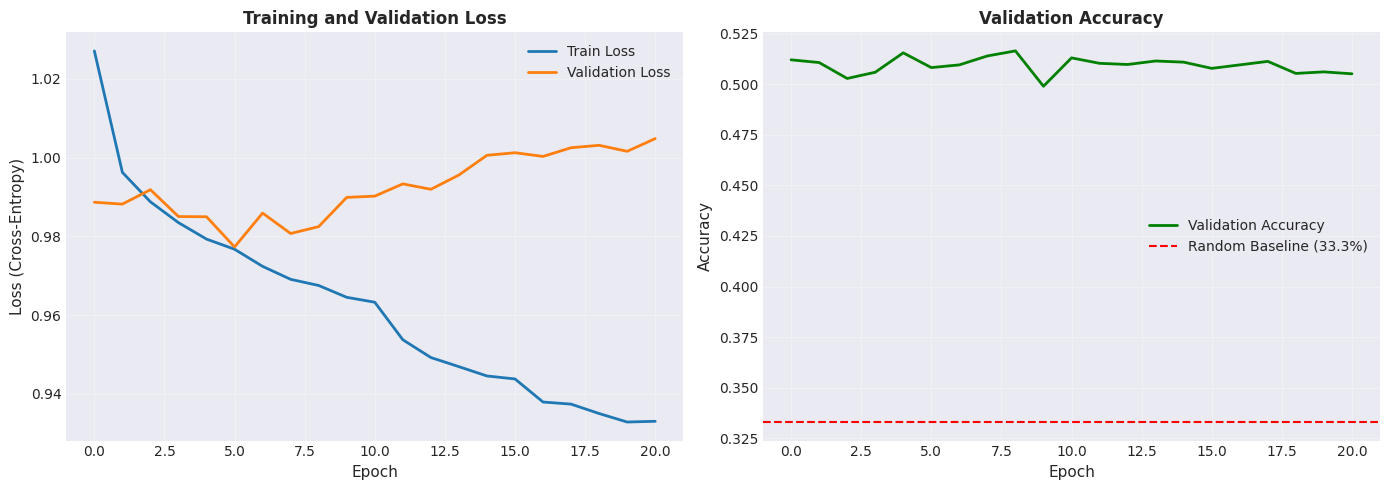


💡 TRAINING ANALYSIS:
   Final train loss: 0.9330
   Final val loss:   1.0048
   ✅ Curves are close - model is not overfitting


In [10]:
# ==============================================================================
# PLOT TRAINING HISTORY
# ==============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss curves
# Good sign: Both curves decreasing, staying close together
# Bad sign: Train loss much lower than val loss (overfitting)
axes[0].plot(model.history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(model.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=11)
axes[0].set_ylabel('Loss (Cross-Entropy)', fontsize=11)
axes[0].set_title('Training and Validation Loss', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy curve
# Good sign: Accuracy increasing and stabilizing
axes[1].plot(model.history['val_acc'], label='Validation Accuracy', 
             linewidth=2, color='green')
axes[1].axhline(y=0.333, color='red', linestyle='--', label='Random Baseline (33.3%)')
axes[1].set_xlabel('Epoch', fontsize=11)
axes[1].set_ylabel('Accuracy', fontsize=11)
axes[1].set_title('Validation Accuracy', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cnn_lstm_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

# Analyze training
final_train_loss = model.history['train_loss'][-1]
final_val_loss = model.history['val_loss'][-1]
print("\n💡 TRAINING ANALYSIS:")
print(f"   Final train loss: {final_train_loss:.4f}")
print(f"   Final val loss:   {final_val_loss:.4f}")
if final_val_loss > final_train_loss * 1.5:
    print("   ⚠️ Gap suggests some overfitting - consider more dropout")
else:
    print("   ✅ Curves are close - model is not overfitting")


## 5. Evaluation on Test Set


In [11]:
# ==============================================================================
# FINAL EVALUATION
# ==============================================================================

print("\n" + "="*60)
print("🎯 TEST SET EVALUATION")
print("="*60)

test_metrics = model.evaluate(X_test, y_test)

print(f"\nTest Set Results:")
print(f"  Accuracy:    {test_metrics['accuracy']:.4f} ({test_metrics['accuracy']:.1%})")
print(f"  F1 Weighted: {test_metrics['f1_weighted']:.4f}")
print(f"  F1 Macro:    {test_metrics['f1_macro']:.4f}")

print(f"\n  Random Baseline: 33.3%")
print(f"  Improvement:     {(test_metrics['accuracy'] - 0.333)*100:+.1f}%")



🎯 TEST SET EVALUATION

Test Set Results:
  Accuracy:    0.5256 (52.6%)
  F1 Weighted: 0.5233
  F1 Macro:    0.5204

  Random Baseline: 33.3%
  Improvement:     +19.3%


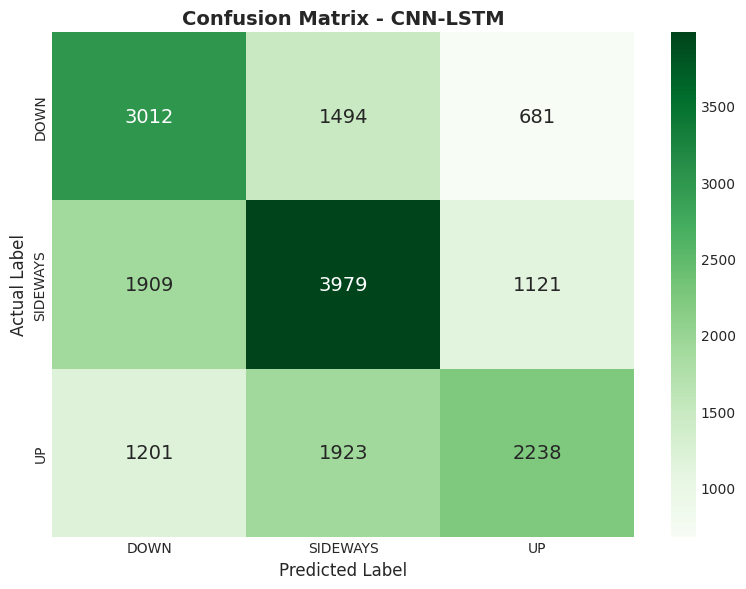

In [12]:
# ==============================================================================
# CONFUSION MATRIX
# ==============================================================================

fig, ax = plt.subplots(figsize=(8, 6))

cm = np.array(test_metrics['confusion_matrix'])
labels = ['DOWN', 'SIDEWAYS', 'UP']

sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels, ax=ax,
            annot_kws={"size": 14})
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('Actual Label', fontsize=12)
ax.set_title('Confusion Matrix - CNN-LSTM', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('cnn_lstm_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()


In [13]:
# ==============================================================================
# SAVE MODEL
# ==============================================================================

print("\n" + "="*60)
print("💾 SAVING MODEL")
print("="*60)

Path('models_artifacts').mkdir(exist_ok=True)
model.save('models_artifacts', name=f'cnn_lstm_h{HORIZON}')
print(f"✅ Model saved: models_artifacts/cnn_lstm_h{HORIZON}_model.keras")



💾 SAVING MODEL
✅ Model saved to models_artifacts
✅ Model saved: models_artifacts/cnn_lstm_h1_model.keras


## 6. Hyperparameter Experiments

**WHY EXPERIMENT WITH LOOKBACK?**

The lookback window is one of the most important hyperparameters:
- Too short: Model can't see enough history
- Too long: Model may overfit to noise

We test several values to find the optimal one.


In [14]:
# ==============================================================================
# LOOKBACK EXPERIMENT
# ==============================================================================
#
# Test different lookback values to find optimal sequence length.
# This takes a while as we train multiple models.

print("\n" + "="*60)
print("🔬 LOOKBACK EXPERIMENTS")
print("="*60)
print("Testing different lookback values...")
print("This will train 4 models and may take 10-15 minutes.\n")

lookback_values = [5, 10, 20, 30]
lookback_results = []

for lb in lookback_values:
    print(f"\n--- Testing lookback={lb} ({lb * 15} minutes of history) ---")
    
    model_exp = CNNLSTMModel(
        n_classes=3,
        lookback=lb,
        conv_filters=16,
        lstm_units=64,
        dropout=0.5,
        device='cuda',
        random_seed=42
    )
    
    # Train with fewer epochs for experiments
    model_exp.fit(
        X_train, y_train, 
        X_val, y_val,
        epochs=50,       # Fewer epochs for speed
        batch_size=64, 
        patience=10,
        scale=True
    )
    
    metrics = model_exp.evaluate(X_test, y_test)
    
    lookback_results.append({
        'lookback': lb,
        'minutes': lb * 15,
        'accuracy': metrics['accuracy'],
        'f1_weighted': metrics['f1_weighted']
    })
    
    print(f"   Accuracy: {metrics['accuracy']:.4f}, F1: {metrics['f1_weighted']:.4f}")

# Display results
print("\n" + "="*60)
print("📊 LOOKBACK COMPARISON RESULTS")
print("="*60)

results_df = pd.DataFrame(lookback_results)
print("\n" + results_df.to_string(index=False))

# Find best
best_idx = results_df['accuracy'].idxmax()
best_lookback = results_df.loc[best_idx, 'lookback']
print(f"\n✅ Best lookback: {best_lookback} candles ({best_lookback * 15} minutes)")



🔬 LOOKBACK EXPERIMENTS
Testing different lookback values...
This will train 4 models and may take 10-15 minutes.


--- Testing lookback=5 (75 minutes of history) ---
🚀 GPU detected: /physical_device:GPU:0

📊 Preparing data...
📊 Creating sequences (lookback=5)...
   Train sequences: (46942, 5, 67)
   Val sequences: (5211, 5, 67)

🏗️ Building model...


Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 5, 67)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 5, 16)          │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 5, 16)          │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 5, 32)          │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 5, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 5, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,123 (520.01 KB)

 Trainable params: 132,899 (519.14 KB)

 Non-trainable params: 224 (896.00 B)


⚖️ Class weights: {np.int32(0): np.float64(1.0179775768221542), np.int32(1): np.float64(1.065459167461074), np.int32(2): np.float64(0.9267002270259599)}

🏋️ Training for up to 50 epochs (patience=10)...
Epoch 1/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.4465 - loss: 1.0497 - val_accuracy: 0.5141 - val_loss: 0.9961 - learning_rate: 0.0010
Epoch 2/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.4906 - loss: 1.0158 - val_accuracy: 0.5296 - val_loss: 0.9855 - learning_rate: 0.0010
Epoch 3/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.4999 - loss: 1.0052 - val_accuracy: 0.5287 - val_loss: 0.9819 - learning_rate: 0.0010
Epoch 4/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5058 - loss: 0.9998 - val_accuracy: 0.5256 - val_loss: 0.9831 - learning_rate: 0.0010
Epoch 5/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5087 - loss: 0.9957 - val_accuracy: 0.5239 - val_loss: 0.9863 - learning_rate: 0.0010
Epoch 6/50
734/734 ━━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 10, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 10, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,123 (520.01 KB)

 Trainable params: 132,899 (519.14 KB)

 Non-trainable params: 224 (896.00 B)


⚖️ Class weights: {np.int32(0): np.float64(1.0182003557638075), np.int32(1): np.float64(1.0653456806936312), np.int32(2): np.float64(0.9266015200868621)}

🏋️ Training for up to 50 epochs (patience=10)...
Epoch 1/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.4552 - loss: 1.0453 - val_accuracy: 0.5065 - val_loss: 0.9895 - learning_rate: 0.0010
Epoch 2/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.4947 - loss: 1.0086 - val_accuracy: 0.5079 - val_loss: 0.9920 - learning_rate: 0.0010
Epoch 3/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5023 - loss: 1.0005 - val_accuracy: 0.5052 - val_loss: 0.9864 - learning_rate: 0.0010
Epoch 4/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5077 - loss: 0.9928 - val_accuracy: 0.5154 - val_loss: 0.9878 - learning_rate: 0.0010
Epoch 5/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5117 - loss: 0.9897 - val_accuracy: 0.5221 - val_loss: 0.9769 - learning_rate: 0.0010
Epoch 6/50
734/734 ━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 20, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 16)         │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 20, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 20, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 20, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 20, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 20, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 20, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,123 (520.01 KB)

 Trainable params: 132,899 (519.14 KB)

 Non-trainable params: 224 (896.00 B)


⚖️ Class weights: {np.int32(0): np.float64(1.018248491949833), np.int32(1): np.float64(1.0652637791700716), np.int32(2): np.float64(0.9266236202436664)}

🏋️ Training for up to 50 epochs (patience=10)...
Epoch 1/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.4368 - loss: 1.0554 - val_accuracy: 0.4673 - val_loss: 1.0415 - learning_rate: 0.0010
Epoch 2/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.4967 - loss: 1.0094 - val_accuracy: 0.5090 - val_loss: 1.0116 - learning_rate: 0.0010
Epoch 3/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.5047 - loss: 0.9975 - val_accuracy: 0.4898 - val_loss: 1.0173 - learning_rate: 0.0010
Epoch 4/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5108 - loss: 0.9913 - val_accuracy: 0.5004 - val_loss: 1.0066 - learning_rate: 0.0010
Epoch 5/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5160 - loss: 0.9866 - val_accuracy: 0.5125 - val_loss: 0.9948 - learning_rate: 0.0010
Epoch 6/50
734/734 ━━━━━━━

Model: "cnn_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 30, 67)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 16)         │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 30, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv1 (Activation)         │ (None, 30, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv1 (Dropout)         │ (None, 30, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 30, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv2 (BatchNormalization)   │ (None, 30, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_conv2 (Activation)         │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv2 (Dropout)         │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_lstm1 (BatchNormalization)   │ (None, 30, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm1 (Dropout)         │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,123 (520.01 KB)

 Trainable params: 132,899 (519.14 KB)

 Non-trainable params: 224 (896.00 B)


⚖️ Class weights: {np.int32(0): np.float64(1.018097780092442), np.int32(1): np.float64(1.065399550378091), np.int32(2): np.float64(0.9266457308763406)}

🏋️ Training for up to 50 epochs (patience=10)...
Epoch 1/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.4479 - loss: 1.0496 - val_accuracy: 0.4925 - val_loss: 1.0234 - learning_rate: 0.0010
Epoch 2/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.4964 - loss: 1.0079 - val_accuracy: 0.5118 - val_loss: 0.9961 - learning_rate: 0.0010
Epoch 3/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5074 - loss: 0.9972 - val_accuracy: 0.5102 - val_loss: 0.9934 - learning_rate: 0.0010
Epoch 4/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5118 - loss: 0.9894 - val_accuracy: 0.5087 - val_loss: 0.9929 - learning_rate: 0.0010
Epoch 5/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.5152 - loss: 0.9857 - val_accuracy: 0.5210 - val_loss: 0.9841 - learning_rate: 0.0010
Epoch 6/50
734/734 ━━━━━━━━

## 7. Summary


In [15]:
# ==============================================================================
# FINAL SUMMARY
# ==============================================================================

print("\n" + "="*60)
print("📋 CNN-LSTM MODEL SUMMARY")
print("="*60)

print(f"""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
⚙️ CONFIGURATION
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Lookback: {LOOKBACK} candles ({LOOKBACK * 15} minutes)
• Architecture: Conv1D(16) → LSTM(64) → Dense(32) → Output(3)
• Dropout: 50%
• Learning Rate: 0.001
• Optimizer: Adam

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📊 TEST SET RESULTS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Accuracy:    {test_metrics['accuracy']:.4f} ({test_metrics['accuracy']:.1%})
• F1 Weighted: {test_metrics['f1_weighted']:.4f}
• F1 Macro:    {test_metrics['f1_macro']:.4f}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🔬 LOOKBACK EXPERIMENT RESULTS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
{results_df.to_string(index=False)}

Best: lookback={best_lookback}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
💾 SAVED FILES
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Model: models_artifacts/cnn_lstm_h{HORIZON}_model.keras
• Training plot: cnn_lstm_training_history.png
• Confusion matrix: cnn_lstm_confusion_matrix.png
""")

print("="*60)
print("✅ CNN-LSTM TRAINING COMPLETE!")
print("="*60)
print("\nNext step: Run 04_comparison.py to compare models.")



📋 CNN-LSTM MODEL SUMMARY

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
⚙️ CONFIGURATION
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Lookback: 10 candles (150 minutes)
• Architecture: Conv1D(16) → LSTM(64) → Dense(32) → Output(3)
• Dropout: 50%
• Learning Rate: 0.001
• Optimizer: Adam

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📊 TEST SET RESULTS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Accuracy:    0.5256 (52.6%)
• F1 Weighted: 0.5233
• F1 Macro:    0.5204

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🔬 LOOKBACK EXPERIMENT RESULTS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
 lookback  minutes  accuracy  f1_weighted
        5       75  0.531401     0.531487
       10      150  0.532236     0.529361
       20      300  0.527695     0.523579
       30      450  0.530847     0.530971

Best: lookback=10

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
💾 SAVED FILES
━━━━━━━━━━━━━━━━━━━━━━━━━━